In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
import matplotlib.patches as mpatches
import plotly.express as px
import plotly.graph_objs as go

from pandas.core.groupby.groupby import DataError

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(colorscale='plotly', world_readable=True)


In [2]:
from pathlib import Path
import os
from openalea.mtg.io import read_mtg_file, write_mtg
from openalea.strawberry.analysis import extract_at_plant_scale, extract_at_node_scale, extract_at_module_scale, df2waffle

In [3]:
def plot_pie(df):
    fig=px.pie(df, values=df.mean(axis=0), names=df.columns)
    return go.FigureWidget(fig) 


In [3]:
def plot_waffle_plotly_heatmap(df, layout={}, legend_name={}):
    
    def df_to_plotly(df):
        return {'z': df.values.tolist(),
                'x': df.columns.tolist(),
                'y': df.index.tolist()}
    
    height = layout.get('height', 500)
    width = layout.get('width', 500)
    xlabel = layout.get('xlabel', 'Plant')
    xticks = layout.get('xticks', range(0,len(df.columns)))
    xticks_label = layout.get('xticks_label', range(1,len(df.columns)+1))
    ylabel = layout.get('ylabel', '')
    yticks = layout.get('yticks', range(0,len(tmp.index)))
    yticks_label = layout.get('yticks_label', list(range(0,len(tmp.index))))
    title = layout.get('title', '')    

    hm_layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)',
                       xaxis={'title':xlabel},
                       yaxis={'title':ylabel}, 
                       autosize=False,
                       width=width, height=height,
                       title=title,
                      )

    data = go.Heatmap(df_to_plotly(df),
                       xgap=1,
                       ygap=1,
                       colorscale="aggrnyl",
                       )

    fig = go.Figure(data=data, layout=hm_layout)

    return fig


def plot_waffle_plotly_imshow(df, layout={}, legend_name={}):
    colormap_used = plt.cm.coolwarm

    values = list(set(df.values.flatten()))
    if '' in values:
        values.remove('')
    try:
        values.sort()
    except TypeError:
        values = [str(i) for i in values]
        values.sort()
    values.insert(0,'')

    color_map = {val: colormap_used(i/len(values)) for i, val in enumerate(values)}

    # Add the "empty" variable - and set its color as white
    color_map[''] = (1., 1., 1., 1.)

    data = np.array(df)

    # Create an array where each cell is a colormap value RGBA 
    data_3d = np.ndarray(shape=(data.shape[0], data.shape[1], 4), dtype=float)
    for i in range(0, data.shape[0]):
        for j in range(0, data.shape[1]):
            data_3d[i][j] = color_map[data[i][j]]

    # drop the A
    data_3d_rgb = np.array([[to_rgb([v for v in row]) for row in col] for col in data_3d], dtype=np.float64)

    yticks = list(range(0,data.shape[0]))
    yticks.reverse()

    fig = px.imshow(data,
                    labels={'x':'Plant', 'y':'Node'},
                    x=list(range(1,data.shape[1]+1)),
                    y=yticks,
                    origin='lower',
                    color_continuous_scale='aggrnyl',
    #                 colorbar={}
                    )
    fig.update_layout(plot_bgcolor='rgba(0,0,0,0)',
                      )
    return fig


def plot_waffle_matplotlib(df, layout={}, legend_name={}):
    height = layout.get('height', 18.5)
    width = layout.get('width', 10.5)
    xlabel = layout.get('xlabel', 'Plant')
    xticks = layout.get('xticks', range(0,len(df.columns)))
    xticks_label = layout.get('xticks_label', range(1,len(df.columns)+1))
    ylabel = layout.get('ylabel', '')
    yticks = layout.get('yticks', range(0,len(tmp.index)))
    yticks_label = layout.get('yticks_label', list(range(0,len(tmp.index))))
    title = layout.get('title', '')    
    
    colormap_used = plt.cm.coolwarm
    
    # Sort the variables. When variables are int or float, remove the str('') (that replaced the NaN) before sorting
    values = list(set(df.values.flatten()))
    if '' in values:
        values.remove('')
    try:
        values.sort()
    except TypeError:
        values = [str(i) for i in values]
        values.sort()
    values.insert(0,'')
    
    w_height = len(df.index)
    w_width = len(df.columns)
    color_map = {val: colormap_used(i/len(values)) for i, val in enumerate(values)}
    
    # Add the "empty" variable - and set its color as white
    color_map[''] = (1., 1., 1., 1.)
    
    data = np.array(df)
    
    # Create an array where each cell is a colormap value RGBA 
    data_3d = np.ndarray(shape=(data.shape[0], data.shape[1], 4), dtype=float)
    for i in range(0, data.shape[0]):
        for j in range(0, data.shape[1]):
            data_3d[i][j] = color_map[data[i][j]]
    
#     display the plot 
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(height, width)
    fig = ax.imshow(data_3d)

    # Get the axis.
    ax = plt.gca()

    # Minor ticks
    ax.set_xticks(np.arange(-.5, (w_width), 1), minor=True);
    ax.set_yticks(np.arange(-.5, (w_height), 1), minor=True);

    # Gridlines based on minor ticks
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

    # Manually constructing a legend solves your "catagorical" problem.
    legend_handles = []

    for i, val in enumerate(values):
        if val!= "":
            color_val = color_map[val]
            legend_handles.append(mpatches.Patch(color=color_val, label=legend_name.get(val, val)))

    # Add the legend. 
    plt.legend(handles=legend_handles, loc=(1,0))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.xticks(ticks=xticks, labels=xticks_label)
    plt.yticks(ticks=yticks, labels=yticks_label)
    
    plt.title(title)

    return fig.axes


def plot_waffle(df, layout={}, legend_name={}, savepath=None, plot_func='matplotlib'):
    """
    Plot a dataframe in "waffle" shape

    layout: dict of layout parameters:
            height/width: size of the picture in inch
            x/ylabel: label of the x/y axis
            x/yticks: ticks of the x/y axis
            x/yticks_labels: labels of the ticks on the x/y axis
            title: title
    plot_func: library used for the ploting:
            matplotlib: matplotlib.pyplot.subplot.imshow
            plotly.imshow: plotly.express.imshow
            plotly.heatmap: plotly.graph_objs.heatmap
    """

    ## Axes not working - Plotly heatmap
    if plot_func=='plotly.heatmap':
        fig= plot_waffle_plotly_heatmap(df=df, layout=layout, legend_name=legend_name)

    # Plotly imshow
    elif plot_func=='plotly.imshow':
        fig= plot_waffle_plotly_imshow(df=df, layout=layout, legend_name=legend_name)

    # With matplotlib
    elif plot_func=='matplotlib':
        fig= plot_waffle_matplotlib(df=df, layout=layout, legend_name=legend_name)

    if savepath:
        plt.savefig(savepath)
    
    return fig

In [4]:
def df2waffle(df, date, index, variable, order=None, aggfunc=None, crosstab=None, *args, **kwargs):
    '''
        Transpose dataframe by variable with plant in columns and rank or order in index
        This function are available for extraction at node scale (index='rank') and 
        extraction at module scale (index= 'order')
        Parameters:
        -----------
            df: dataframe from extract function at differente scale (modules and nodes scale)
            date_selected: date which must be processed
            variable: variable which must be processed
        
        Returns:
        --------
            a dataframe in "waffle" shape: index=date, & columns=variable
    '''

    if order:
        data=df[(df['date']==date) & (df['order']==order)]
    else:
        data=df[df['date']==date]
    
    if index=='rank':
        res = data.pivot(index='rank',columns='plant',values=variable)
    elif index=='order':
        if crosstab:
            res = pd.crosstab(index=data['order'], columns=data[variable], normalize='index')
            res=res*100
            res = res.round(2)
        else:
            # Catch data error: when values are string and aggfunc compute numbers
            try:
                res= data.pivot_table(index='order',columns='plant',values=variable, aggfunc=aggfunc)
            except DataError:
                print("ERROR, the aggregate function does not handle the data type (float func on str?)")
                return pd.DataFrame()
            
    else:
        res = data.pivot(index=index,columns='plant',values=variable)
    
    # If use plotly heatmap -> comment "res = res.fillna('')"
    if res.isnull().values.any():
        res = res.fillna('')
    res = res.sort_index(ascending=False)
    return res


In [5]:
files_names=[]
# START BY LOADING ALL EXISTING MTG FILES IN /dashboard_files
home = str(Path.home())
data_directory = os.path.join(home, "dashboard_files")
file_paths = {}
for file in os.listdir(data_directory):
    if file.endswith(".mtg"):
        file_paths[file] = os.path.join(data_directory, file)
        
    files_names.append(file)
mtg1 = read_mtg_file(file_paths[files_names[0]])


In [6]:
df = extract_at_node_scale(mtg1)

In [10]:
date = df['date']

tmp = df2waffle(df, 
                index='rank', 
                date=date[len(date)-1], 
                variable='branching_type', 
                order=None)

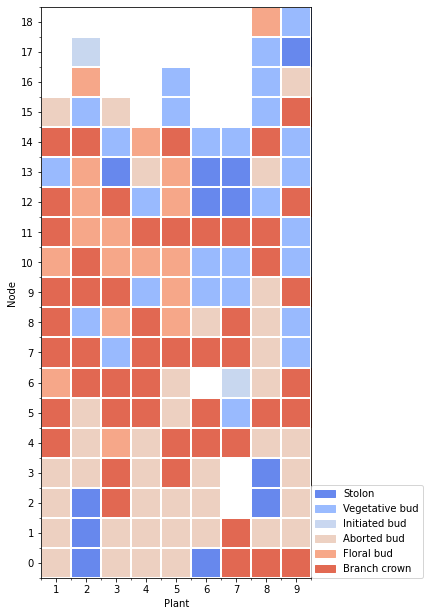

In [11]:
l_names = {"1":"Stolon", 
           "2":"Vegetative bud",
           "3":"Initiated bud",
           "4":"Aborted bud",
           "5":"Floral bud",
           "6":"Branch crown"}

yticks_l =[l-1 for l in list(tmp.index)]
layout={
    'xlabel': 'Plant',
    'xticks': range(0,len(tmp.columns)),
    'xticks_label': list(tmp.columns),
    'ylabel': 'Node',
    'yticks': range(0,len(tmp.index)),
    'yticks_label': yticks_l,
}


fig=plot_waffle(tmp, 
                layout=layout, 
                legend_name=l_names, 
                plot_func='matplotlib')
# fig

False

In [9]:
tmp

plant,1,2,3,4,5,6,7,9
rank,,,,,,,,
18,,3,,,,,,
17,,5,,,,,,
16,4,2,,,,,,6
15,6,,,5,6,2,,2
14,2,,,4,5,1,,2
13,,,6,2,5,1,,
12,,,5,,,,6,
11,,,5,,,,2,
10,,,,,,,2,


In [12]:
# for file in file_paths:
#     mtg1 = read_mtg_file(file_paths[file])
#     df = extract_at_node_scale(mtg1)
#     date = df['date']
#     tmp = df2waffle(df, index='rank', date=date[len(date)-1], variable='branching_type')
#     name = file[:-4] + "_waffle_node_branch_type.png"

#     fig=plot_waffle(tmp, ylabel='Node', savepath=name)
    


In [12]:
df

,node_id,rank,branching_type,complete,nb_modules_branching,nb_branch_crown_branching,nb_extension_crown_branching,branching_length,stage,Genotype,order,date,plant
0,3,1,1,other,0,0,0,0,None,Clery,0,2014/12/10,1
1,6,2,2,other,0,0,0,0,None,Clery,0,2014/12/10,1
2,12,3,None,other,0,0,0,0,None,Clery,0,2014/12/10,1
3,13,4,5,other,0,0,0,0,None,Clery,0,2014/12/10,1
4,19,5,1,other,0,0,0,0,None,Clery,0,2014/12/10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
684,5595,15,2,other,0,0,0,0,None,Clery,3,2015/05/27,9
685,5598,16,6,complete,0,0,0,0,None,Clery,3,2015/05/27,9
686,5600,17,4,other,0,0,0,0,None,Clery,4,2015/05/27,9
687,5603,18,1,other,0,0,0,0,None,Clery,4,2015/05/27,9


In [96]:
tmp

plant,1,2,3,4,5,6,7,8,9
rank,,,,,,,,,
19,,,,,,,,5,2
18,,3,,,,,,2,1
17,,5,,,2,,,2,4
16,4,2,4,,2,,,2,6
15,6,6,2,5,6,2,2,6,2
14,2,5,1,4,5,1,1,4,2
13,6,5,6,2,5,1,1,2,6
12,6,5,5,6,6,6,6,6,2
11,5,6,5,5,5,2,2,6,2


In [151]:

import ipywidgets as widgets
layout_output_wgt = {'border': '1px solid black', 'margin':'0px', 'padding':'0px'}
p4_waffle = widgets.Output(layout=layout_output_wgt)
p4_waffle

Output(layout=Layout(border='1px solid black', margin='0px', padding='0px'))

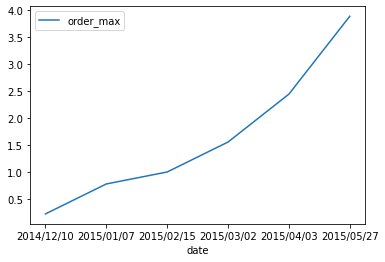

In [153]:
with p4_waffle:
    p4_waffle.clear_output()
    df = extract_at_plant_scale(mtg1)
    n = df.groupby('date').mean()
    print(n.plot(y='order_max'))

In [129]:
with p4_waffle:
    p4_waffle.clear_output()
    try:
        display(plot_pie(tmp))
    except ValueError:
        pass

In [130]:
p4_waffle

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': "FigureWidget({\n    'data': [{'domain'…

In [148]:
p4_wgt_occurence = go.FigureWidget(layout={'plot_bgcolor': 'rgba(0,0,0,0)'})
p4_wgt_occurence

FigureWidget({
    'data': [], 'layout': {'plot_bgcolor': 'rgba(0,0,0,0)', 'template': '...'}
})

In [140]:
def transfert_figure_pie(source, cible):
    cible.data = []
    cible.layout = {}
    cible.update_layout(source.layout)
    for trace in source.data:
        cible.add_pie(**trace.to_plotly_json())
        
transfert_figure_pie(plot_pie(tmp), p4_wgt_occurence)

In [146]:
f=plot_pie(tmp)
print(f.layout)

Layout({
    'legend': {'tracegroupgap': 0}, 'margin': {'t': 60}, 'template': '...'
})


In [ ]:
p4_wgt_occurence.add_pie()

In [12]:
df = extract_at_module_scale(mtg1)
df

,Genotype,date,modality,plant,order,nb_visible_leaves,nb_foliar_primordia,nb_total_leaves,nb_open_flowers,nb_aborted_flowers,...,nb_vegetative_bud,nb_initiated_bud,nb_floral_bud,nb_stolons,type_of_crown,crown_status,complete_module,stage,vid,plant_vid
0,Clery,2014/12/10,A,1,0,11,2,13,0,0,...,1,0,8,3,1,3,False,H,2,1
1,Clery,2014/12/10,A,2,0,11,3,14,0,0,...,5,2,4,3,1,3,False,H,102,101
2,Clery,2014/12/10,A,3,0,8,2,10,0,0,...,3,0,5,2,1,3,False,H,189,188
3,Clery,2014/12/10,A,4,0,4,0,4,0,0,...,0,0,0,3,1,4,True,cut,255,254
4,Clery,2014/12/10,A,4,1,2,2,4,0,0,...,0,0,4,0,2,3,False,H,266,254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,Clery,2015/05/27,A,9,3,3,0,3,3,0,...,1,0,1,1,2,4,True,65,5553,5453
259,Clery,2015/05/27,A,9,1,3,0,3,8,0,...,2,0,0,0,2,4,True,87,5575,5453
260,Clery,2015/05/27,A,9,2,3,0,3,4,0,...,2,0,0,0,2,4,True,87,5583,5453
261,Clery,2015/05/27,A,9,3,3,0,3,4,0,...,2,0,0,0,2,4,True,77,5591,5453


In [13]:
date = df['date']

def concat_string(x):
    return ' '.join(x)

# lambda x: ' '.join(x)

tmp=df2waffle(df, index='order', 
              date=date[len(date)-1], 
              variable='stage', 
              aggfunc=concat_string,
              crosstab=False)
tmp

plant,1,2,3,4,5,6,7,8,9
order,,,,,,,,,
4,17,I 57,57 55,H A,I,,I I,H H,57 57
3,H H 60 67,73 60,57 60 I 73,aborted 57 60 67,65 67,H,57 57 aborted aborted,77 H H,57 73 65 77
2,H 60 aborted 87,87 60 aborted,87 aborted 87,H aborted 87 87,87 87,57 57,87 87,87 aborted H aborted 57,73 87 87 87
1,87 87,87 87,87 87,87 87,87 87,87 87,87 87,87 87 87 87,87 87 87
0,87,87,87,87,87,87,aborted,87,87


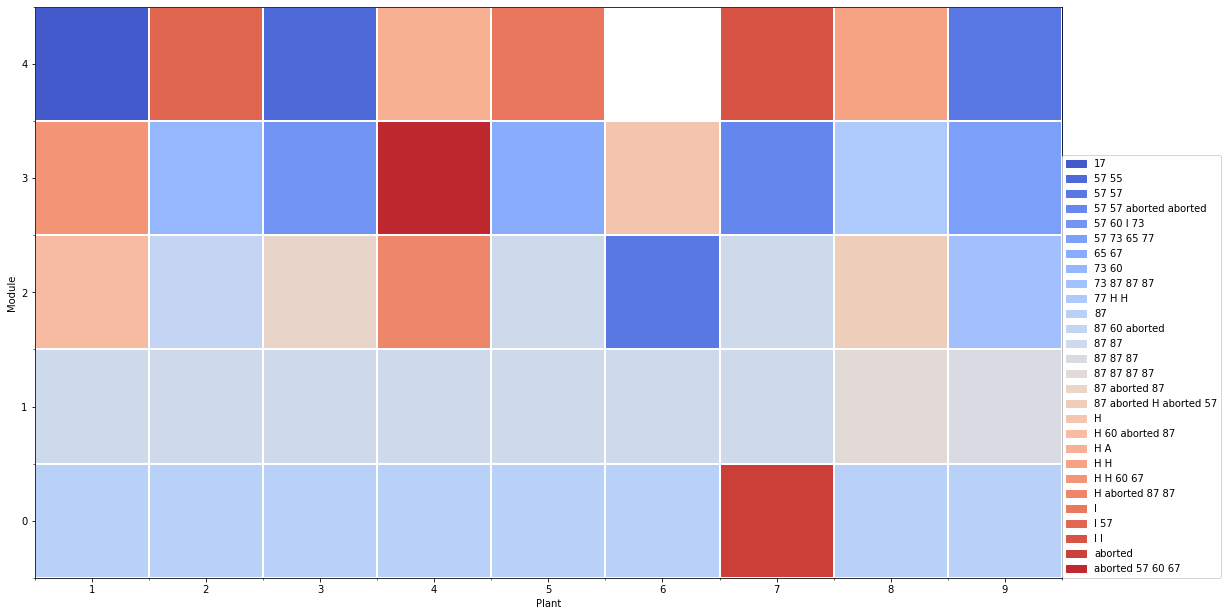

In [14]:
yticks_l =list(range(0,len(tmp.index)))
yticks_l.reverse()

layout={
    'xlabel': 'Plant',
    'xticks': range(0,len(tmp.columns)),
    'xticks_label': tmp.columns,
    'ylabel': 'Module',
    'yticks': range(0,len(tmp.index)),
    'yticks_label': yticks_l,
}


ax = plot_waffle(tmp,
                  layout=layout,
                  plot_func='matplotlib')
# fig


In [15]:
ax

<AxesSubplot:xlabel='Plant', ylabel='Module'>

In [16]:
tmp=df2waffle(df, index='order', 
              date=date[len(date)-1], 
              variable='stage', 
              crosstab=True)
tmp

stage,17,55,57,60,65,67,73,77,87,A,H,I,aborted
order,,,,,,,,,,,,,
4,7.14,7.14,28.57,0.00,0.00,0.00,0.00,0.00,0.00,7.14,21.43,28.57,0.00
3,0.00,0.00,17.86,14.29,7.14,10.71,10.71,7.14,0.00,0.00,17.86,3.57,10.71
2,0.00,0.00,10.34,6.90,0.00,0.00,3.45,0.00,48.28,0.00,10.34,0.00,20.69
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,88.89,0.00,0.00,0.00,11.11


In [36]:
yticks_l =list(range(0,len(tmp.index)))
yticks_l.reverse()

layout={
    'xlabel': 'Stage',
    'xticks': range(0,len(tmp.columns)),
    'xticks_label': tmp.columns,
    'ylabel': 'Module',
    'yticks': range(0,len(tmp.index)),
    'yticks_label': yticks_l,
    'width': 500
}


fig = plot_waffle(tmp,
                  layout=layout,
                  plot_func='plotly.heatmap')
fig.show()

px.pie(tmp, values=tmp.mean(axis=0), names=tmp.columns)


In [37]:
tmp

plant,1,2,3,4,5,6,7,8,9
rank,,,,,,,,,
19,,,,,,,,5,2
18,,3,,,,,,2,1
17,,5,,,2,,,2,4
16,4,2,4,,2,,,2,6
15,6,6,2,5,6,2,2,6,2
14,2,5,1,4,5,1,1,4,2
13,6,5,6,2,5,1,1,2,6
12,6,5,5,6,6,6,6,6,2
11,5,6,5,5,5,2,2,6,2


In [ ]:
px.pie(tmp, values=tmp.mean(axis=0), names=tmp.columns)


In [96]:
tmp

plant,1,2,3,4,5,6,7,8,9
order,,,,,,,,,
4,17,I 57,57 55,H A,I,,I I,H H,57 57
3,H H 60 67,73 60,57 60 I 73,aborted 57 60 67,65 67,H,57 57 aborted aborted,77 H H,57 73 65 77
2,H 60 aborted 87,87 60 aborted,87 aborted 87,H aborted 87 87,87 87,57 57,87 87,87 aborted H aborted 57,73 87 87 87
1,87 87,87 87,87 87,87 87,87 87,87 87,87 87,87 87 87 87,87 87 87
0,87,87,87,87,87,87,aborted,87,87


In [71]:
tmp = df[df['date'] == date[len(date)-1]]

tmp = pd.crosstab(index=tmp['order'], 
                  columns=tmp['stage'], 
                  normalize='index')
tmp=tmp*100
# tmp = tmp.mean(axis=0)
tmp = tmp.round(2)
px.pie(tmp, values=tmp.mean(axis=0), names=tmp.columns)


In [177]:
tmp

stage,17,55,57,60,65,67,73,77,87,A,H,I,aborted
order,,,,,,,,,,,,,
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,88.89,0.00,0.00,0.00,11.11
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00
2,0.00,0.00,10.34,6.90,0.00,0.00,3.45,0.00,48.28,0.00,10.34,0.00,20.69
3,0.00,0.00,17.86,14.29,7.14,10.71,10.71,7.14,0.00,0.00,17.86,3.57,10.71
4,7.14,7.14,28.57,0.00,0.00,0.00,0.00,0.00,0.00,7.14,21.43,28.57,0.00


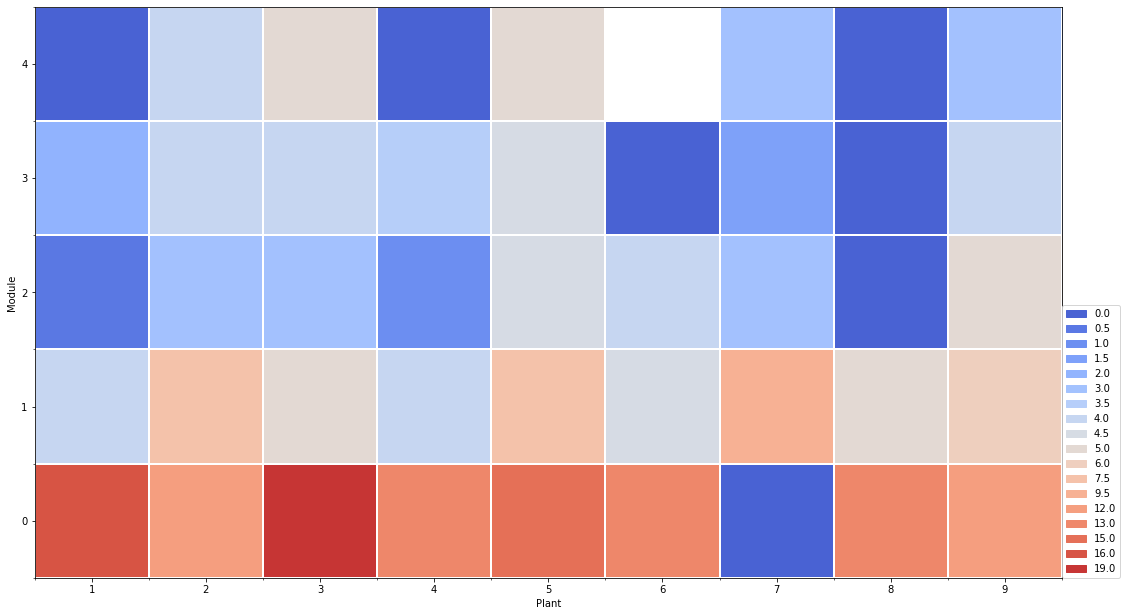

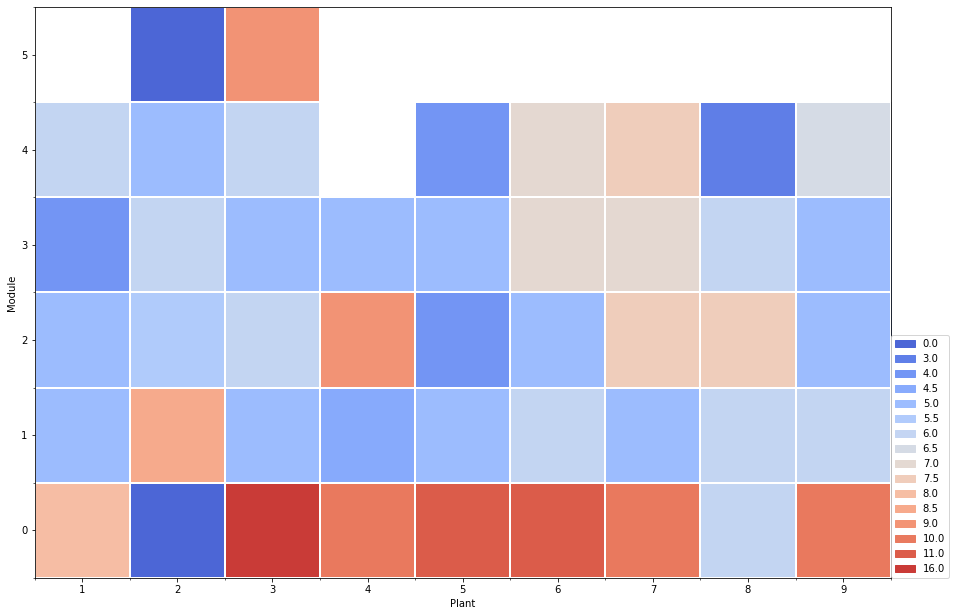

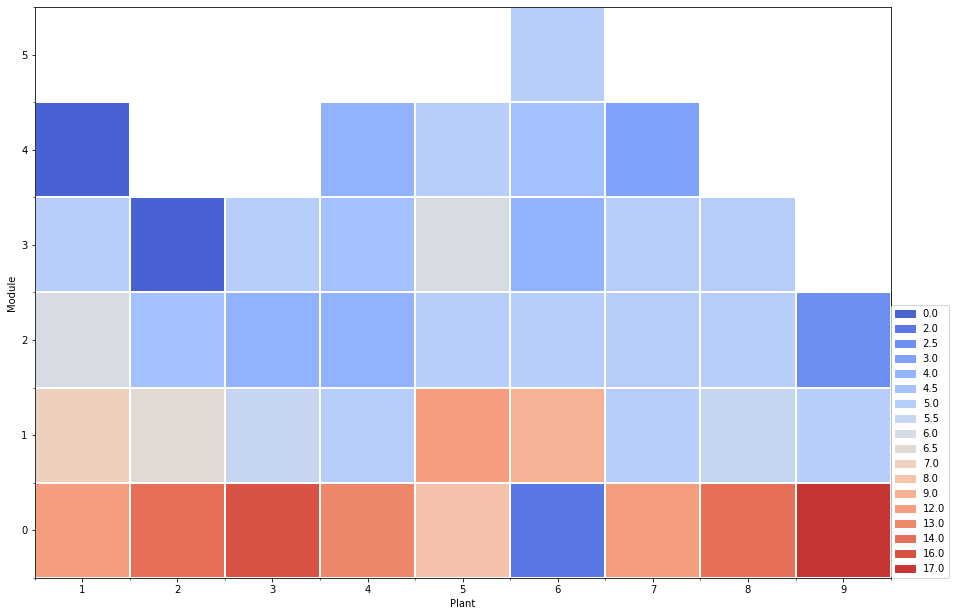

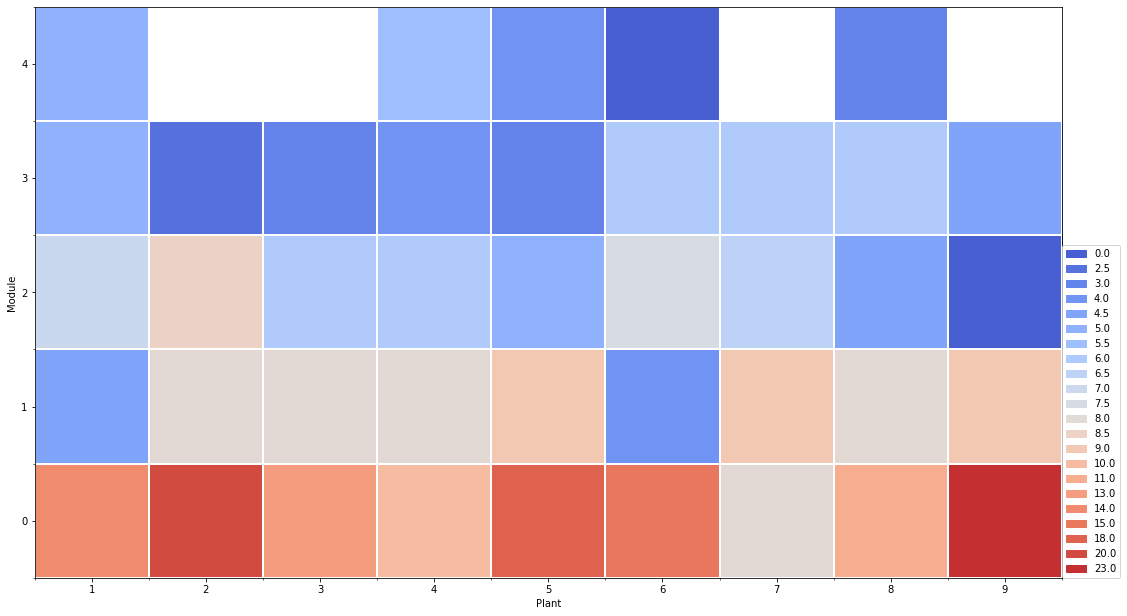

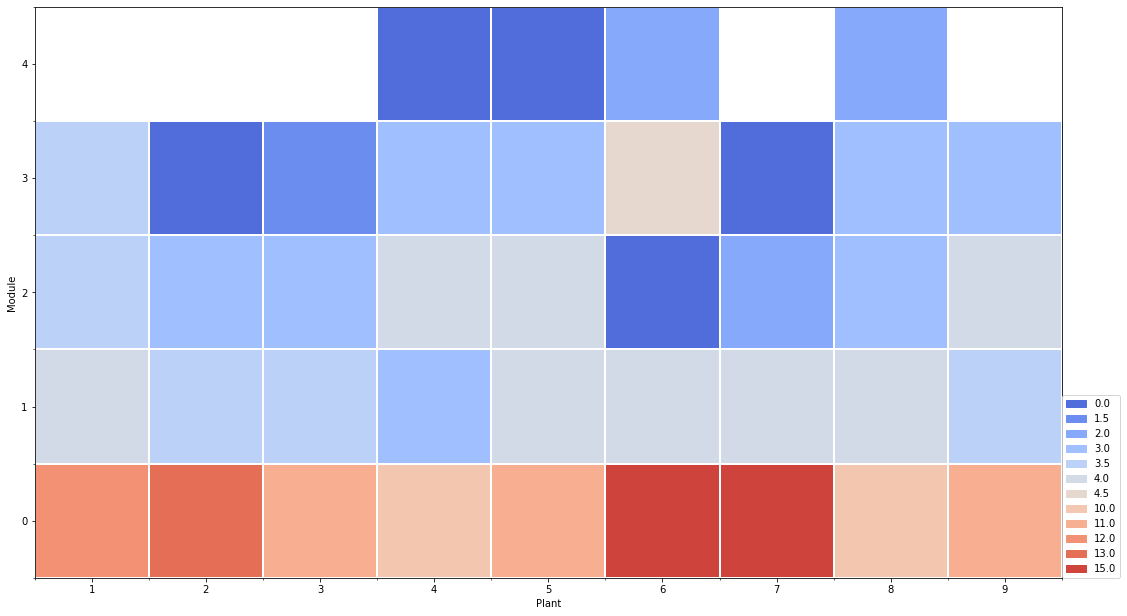

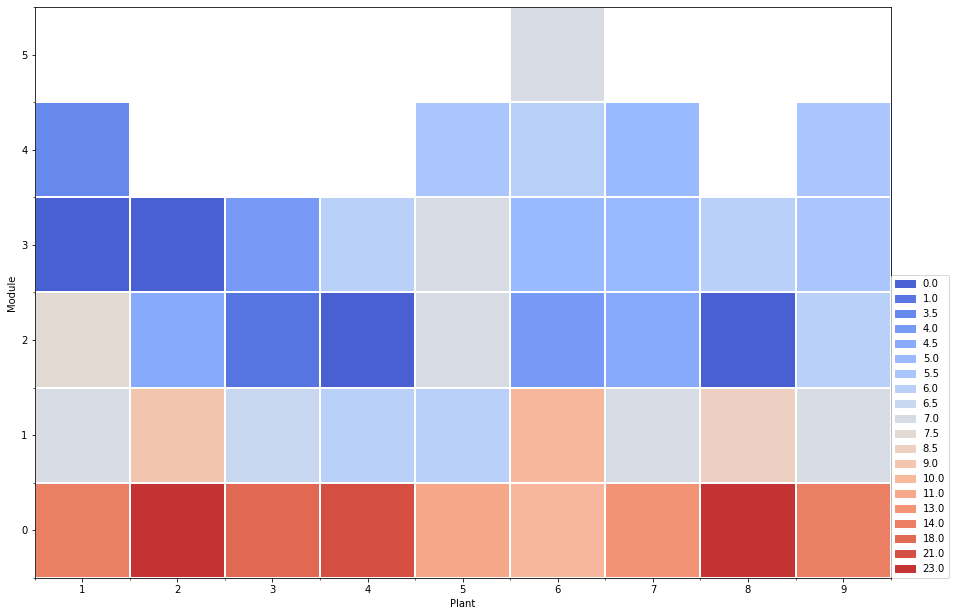

In [25]:
# for file in file_paths:
#     mtg1 = read_mtg_file(file_paths[file])
#     df = extract_at_module_scale(mtg1)
#     date = df['date']
#     tmp = df2waffle(df, index='order', date=date[len(date)-1], variable='nb_total_flowers', aggfunc='median')
#     name = file[:-4] + "_waffle_module_nb_total_flowers.png"

#     fig=plot_waffle(tmp, ylabel='Module', savepath=name)
    

In [15]:
from pathlib import Path
import os
from openalea.mtg.io import read_mtg_file, write_mtg
from openalea.strawberry.analysis import extract_at_node_scale, extract_at_module_scale
from openalea.deploy.shared_data import shared_data
import openalea.strawberry

from openalea.strawberry.analysis import df2waffle

def name(f):
    return f.basename().splitext()[0]

def test_df2waffle():
    files = shared_data(openalea.strawberry).glob('*.mtg')
    mtg_path = dict((name(f), f) for f in files)
    mtg = read_mtg_file(mtg_path['Capriss'])

    df = extract_at_node_scale(mtg)

    node_scale = df2waffle(df, index='rank', date='2015/03/02', variable='branching_type')
    assert node_scale.shape == (20, 9)

    df = extract_at_module_scale(mtg)
    module_scale=df2waffle(df, index='order', date='2015/03/02', variable='crown_status', aggfunc='median')
    assert module_scale.shape == (5, 9)



In [180]:
df = extract_at_node_scale(mtg1)
df

,node_id,rank,branching_type,complete,nb_modules_branching,nb_branch_crown_branching,nb_extension_crown_branching,branching_length,Genotype,order,date,plant
0,3,1,1,other,0,0,0,0,Clery,0,2014/12/10,1
1,6,2,2,other,0,0,0,0,Clery,0,2014/12/10,1
2,12,3,None,other,0,0,0,0,Clery,0,2014/12/10,1
3,13,4,5,other,0,0,0,0,Clery,0,2014/12/10,1
4,19,5,1,other,0,0,0,0,Clery,0,2014/12/10,1
...,...,...,...,...,...,...,...,...,...,...,...,...
684,5595,15,2,other,0,0,0,0,Clery,3,2015/05/27,9
685,5598,16,6,complete,0,0,0,0,Clery,3,2015/05/27,9
686,5600,17,4,other,0,0,0,0,Clery,4,2015/05/27,9
687,5603,18,1,other,0,0,0,0,Clery,4,2015/05/27,9


In [ ]:
vids = g.vertices(scale=1)
